<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/Combined_matrices_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
from google.colab import drive
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from keras.layers import LSTM, Dropout, GRU, Input, Reshape
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def covariance(matrix):
  res_mat = np.cov(matrix,bias=True)
  return res_mat

In [15]:
def loadMatricesLong(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [16]:
def loadMatricesShort(dir):
  matrices_c1 = []
  matrices_c2 = []
  matrices_c3 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
      matrices_c3.extend([covariance(matrix) for matrix in end_trial[2]])
      matrices_c3.extend([covariance(matrix) for matrix in last_beep[2]])
  # return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2),np.array(matrices_c3)),axis=0)

#SHORT CLASSES (OUT, IN, UP) LONG CLASSES (COOPERATE, INDEPENDENT)

In [17]:
def loadMatrices():
  short_mat=[]
  long_mat=[]
  
  short_mat = loadMatricesShort("drive/My Drive/dataset/Short_words/")
  long_mat = loadMatricesLong("drive/My Drive/dataset/Long_words/")
  return np.concatenate((short_mat,long_mat),axis=0)


In [18]:
train_data = loadMatrices()

In [20]:
train_data.shape

(5000, 64, 64)

In [21]:
labels = np.concatenate((np.zeros(1000),np.ones(1000),np.full(1000,2),np.full(1000,3),np.full(1000,4)),axis=0)
print(labels)

[0. 0. 0. ... 4. 4. 4.]


In [23]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=5)
# labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(5000, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [30]:
visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
lstm1 = GRU(64,activation="relu",return_sequences=True)(visible)
lstm2 = GRU(64,activation="relu")(lstm1)
d3 = Dense(64, activation='relu')(lstm2)
d4 = Dense(64, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(5, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 63, 64)       8256        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 60, 64)       16448       conv1d_2[0][0]                   
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_3[0][0]                   
_______________________________________________________________________________________

In [31]:
optimizer = Adam(learning_rate=0.00001)

In [32]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
train_data, labels = shuffle(train_data, labels)

In [34]:
print(labels.shape,train_data.shape)

(5000, 5) (5000, 64, 64)


Iteration no  0  for training 
Epoch 1/100
125/125 [==============================] - 12s 94ms/step - loss: 200.4553 - accuracy: 0.2270 - val_loss: 1.9838 - val_accuracy: 0.2550
Epoch 2/100
125/125 [==============================] - 11s 89ms/step - loss: 159.0801 - accuracy: 0.2812 - val_loss: 1.7153 - val_accuracy: 0.2960
Epoch 3/100
125/125 [==============================] - 11s 90ms/step - loss: 122.3518 - accuracy: 0.2945 - val_loss: 1.6008 - val_accuracy: 0.3120
Epoch 4/100
125/125 [==============================] - 11s 90ms/step - loss: 97.2392 - accuracy: 0.3083 - val_loss: 1.5553 - val_accuracy: 0.3370
Epoch 5/100
125/125 [==============================] - 11s 90ms/step - loss: 76.5293 - accuracy: 0.3203 - val_loss: 1.8038 - val_accuracy: 0.2830
Epoch 6/100
125/125 [==============================] - 11s 89ms/step - loss: 56.2645 - accuracy: 0.3162 - val_loss: 1.5453 - val_accuracy: 0.3510
Epoch 7/100
125/125 [==============================] - 11s 89ms/step - loss: 44.2911 - acc

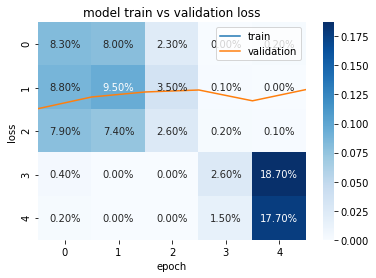

Iteration no  1  for training 
Epoch 1/100
125/125 [==============================] - 12s 96ms/step - loss: 1.2904 - accuracy: 0.4635 - val_loss: 3.1675 - val_accuracy: 0.4700
Epoch 2/100
125/125 [==============================] - 12s 94ms/step - loss: 1.1743 - accuracy: 0.4735 - val_loss: 2.7102 - val_accuracy: 0.4700
Epoch 3/100
125/125 [==============================] - 12s 93ms/step - loss: 1.0949 - accuracy: 0.4753 - val_loss: 2.1701 - val_accuracy: 0.4810
Epoch 4/100
125/125 [==============================] - 12s 93ms/step - loss: 1.0306 - accuracy: 0.4793 - val_loss: 6.2814 - val_accuracy: 0.4680
Epoch 5/100
125/125 [==============================] - 12s 93ms/step - loss: 1.3483 - accuracy: 0.4787 - val_loss: 16.4999 - val_accuracy: 0.4750
Epoch 6/100
125/125 [==============================] - 12s 92ms/step - loss: 1.1293 - accuracy: 0.4865 - val_loss: 2.3610 - val_accuracy: 0.4580
Epoch 7/100
125/125 [==============================] - 12s 95ms/step - loss: 0.9621 - accuracy: 0.

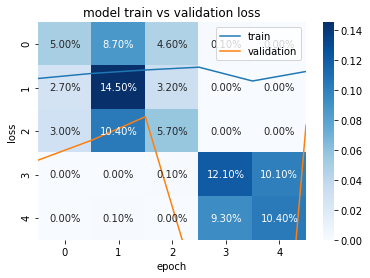

Iteration no  2  for training 
Epoch 1/100
125/125 [==============================] - 12s 92ms/step - loss: 1.7264 - accuracy: 0.5673 - val_loss: 103.3974 - val_accuracy: 0.5350
Epoch 2/100
125/125 [==============================] - 12s 93ms/step - loss: 3.5685 - accuracy: 0.5353 - val_loss: 33.8639 - val_accuracy: 0.5540
Epoch 3/100
125/125 [==============================] - 12s 93ms/step - loss: 1.3441 - accuracy: 0.5312 - val_loss: 13.5232 - val_accuracy: 0.5700
Epoch 4/100
125/125 [==============================] - 12s 93ms/step - loss: 2.4483 - accuracy: 0.5523 - val_loss: 43.5344 - val_accuracy: 0.5780
Epoch 5/100
125/125 [==============================] - 12s 93ms/step - loss: 1.2630 - accuracy: 0.5665 - val_loss: 7.3722 - val_accuracy: 0.5230
Epoch 6/100
125/125 [==============================] - 12s 92ms/step - loss: 0.9232 - accuracy: 0.5548 - val_loss: 1.2702 - val_accuracy: 0.5610
Epoch 7/100
125/125 [==============================] - 12s 93ms/step - loss: 0.8456 - accuracy

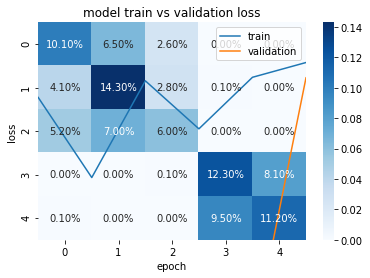

Iteration no  3  for training 
Epoch 1/100
125/125 [==============================] - 11s 88ms/step - loss: 7.1455 - accuracy: 0.5600 - val_loss: 1.1206 - val_accuracy: 0.5610
Epoch 2/100
125/125 [==============================] - 11s 88ms/step - loss: 0.8848 - accuracy: 0.5608 - val_loss: 0.8538 - val_accuracy: 0.5920
Epoch 3/100
125/125 [==============================] - 11s 87ms/step - loss: 0.8262 - accuracy: 0.5807 - val_loss: 0.9563 - val_accuracy: 0.5910
Epoch 4/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7909 - accuracy: 0.6055 - val_loss: 1.0408 - val_accuracy: 0.5940
Epoch 5/100
125/125 [==============================] - 11s 90ms/step - loss: 0.7826 - accuracy: 0.6080 - val_loss: 1.0707 - val_accuracy: 0.6160
Epoch 6/100
125/125 [==============================] - 11s 87ms/step - loss: 15.5985 - accuracy: 0.5968 - val_loss: 0.9143 - val_accuracy: 0.5870
Epoch 7/100
125/125 [==============================] - 11s 87ms/step - loss: 8.5203 - accuracy: 0.

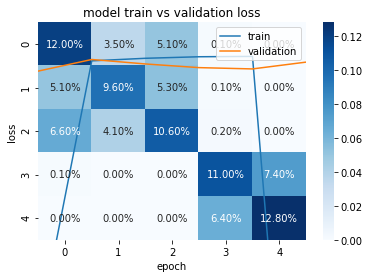

Iteration no  4  for training 
Epoch 1/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7327 - accuracy: 0.6373 - val_loss: 0.9342 - val_accuracy: 0.6040
Epoch 2/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7347 - accuracy: 0.6330 - val_loss: 0.9389 - val_accuracy: 0.6150
Epoch 3/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7219 - accuracy: 0.6355 - val_loss: 1.0830 - val_accuracy: 0.6050
Epoch 4/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7201 - accuracy: 0.6453 - val_loss: 0.9125 - val_accuracy: 0.5970
Epoch 5/100
125/125 [==============================] - 11s 87ms/step - loss: 0.7128 - accuracy: 0.6478 - val_loss: 1.3103 - val_accuracy: 0.5960
Epoch 6/100
125/125 [==============================] - 11s 88ms/step - loss: 0.7155 - accuracy: 0.6445 - val_loss: 1.3083 - val_accuracy: 0.6000
Epoch 7/100
125/125 [==============================] - 11s 89ms/step - loss: 0.7350 - accuracy: 0.6

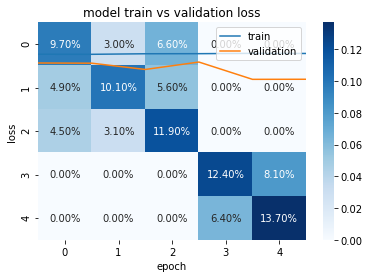

In [35]:
for i in range(5):
  print("Iteration no ",i," for training \n=========\n=========\n=========")

  train_data, labels = shuffle(train_data, labels)

  divide_percent=(len(train_data)*0.2)
  x_test=train_data[0:int(divide_percent)]
  y_test=labels[0:int(divide_percent)]
  x_train = train_data[int(divide_percent):len(train_data)]
  y_train = labels[int(divide_percent):len(labels)]
  
  history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)
  predictions = model.predict(x_test,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_test, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  print("Loss Comparison ====================================================")
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

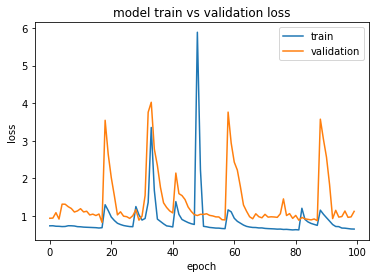

In [37]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()